<a href="https://colab.research.google.com/github/datamino/PINNs/blob/main/case1_p2_(LOHF).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [192]:
import torch
import torch.nn as nn
from torchinfo import summary
import matplotlib.pyplot as plt
import torch.optim as optim

In [193]:
# Radioactive Decay

# Given parameters
lambda_decay = 0.5 # Decay constant
N0 = 100 # Initial number of atoms


# Differntial Equation =>   dN/dt=-λN
# Inital Condition     =>   N(0)=N0
# Solution of DE       =>   N=N0 * torch.exp(-lambda_decay * t)

def true_solution(t):
    return N0 * torch.exp(-lambda_decay * t)

In [194]:
class PINNS(nn.Module):
  def __init__(self,n_features=1):
    super().__init__()
    self.net=nn.Sequential(
        nn.Linear(n_features,20),
        nn.Tanh(),
        nn.Linear(20,20),
        nn.Tanh(),
        nn.Linear(20,1)
    )

  def forward(self,X):
      return self.net(X)



In [195]:
model=PINNS()

In [196]:
summary(model)

Layer (type:depth-idx)                   Param #
PINNS                                    --
├─Sequential: 1-1                        --
│    └─Linear: 2-1                       40
│    └─Tanh: 2-2                         --
│    └─Linear: 2-3                       420
│    └─Tanh: 2-4                         --
│    └─Linear: 2-5                       21
Total params: 481
Trainable params: 481
Non-trainable params: 0

In [197]:
def loss(model,t):
      t = t.clone().detach().requires_grad_(True)
      N=model(t)
      dN_dt=torch.autograd.grad(N,t,torch.ones_like(t),create_graph=True)[0]
      eqaution_loss=torch.mean((dN_dt + lambda_decay * N) ** 2)
      t0 = torch.tensor([[0.0]])
      N_pred=model(t0)
      initial_loss=(N0-N_pred)**2
      total_loss= eqaution_loss+initial_loss
      return total_loss


In [198]:
# optimizer=optim.SGD(model.parameters(),lr=0.1)
optimizer = optim.Adam(model.parameters(), lr=0.01)


Epoch 1/5000, Loss: 9979.603515625
Epoch 1001/5000, Loss: 3.2451705932617188
Epoch 2001/5000, Loss: 0.004326850175857544
Epoch 3001/5000, Loss: 0.000980654265731573
Epoch 4001/5000, Loss: 0.0007051650318317115


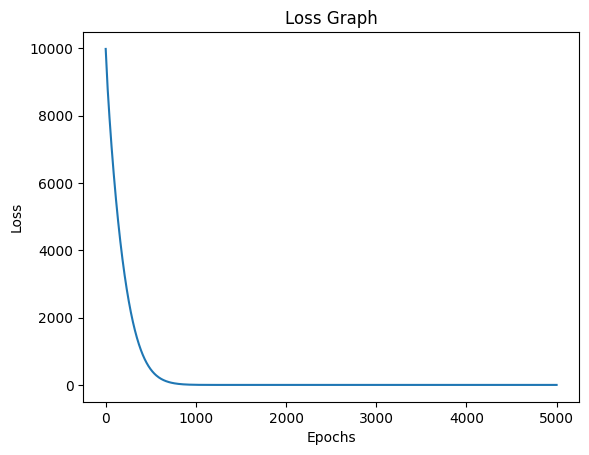

In [199]:
t_train=torch.linspace(0,5,100).view(-1,1)
epochs=5000

loss_history=[]
for epoch in range(epochs):
       optimizer.zero_grad()
       loss_=loss(model,t_train)
       loss_.backward()
       loss_history.append(loss_.item())
       if epoch%1000==0:
        print(f'Epoch {epoch+1}/{epochs}, Loss: {loss(model,t_train).item()}')
       optimizer.step()

plt.plot(loss_history)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss Graph")
plt.show()




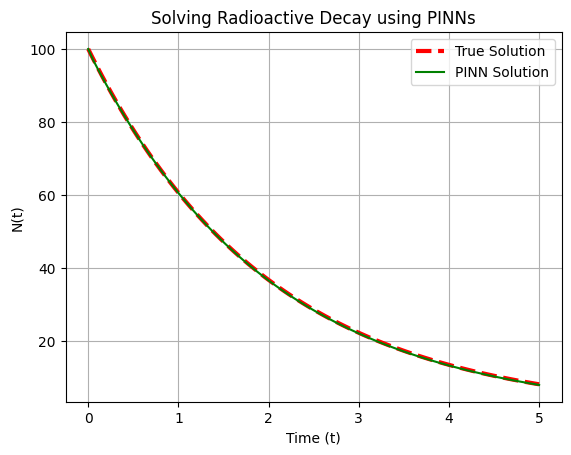

In [200]:
t_test = torch.linspace(0, 5, 100).view(-1, 1)
N_pred = model(t_test).detach().numpy()

plt.plot(t_test, true_solution(t_test), linestyle="dashed", linewidth=3, label="True Solution", color="red")
plt.plot(t_test, N_pred, label="PINN Solution", color="green")
plt.xlabel("Time (t)")
plt.ylabel("N(t)")
plt.legend()
plt.title("Solving Radioactive Decay using PINNs")
plt.grid()
plt.show()